## Table of Contents

### 1.  Overview
### 2.  Download Libraries
### 3.  Download, Clean and Merge Location Data for Costco and RV Parks
### 4.  Download and Clean Demographic Data from the Census Bureau
### 5.  Merge Demographic Dataset with Merged Costco and RV Parks Dataset
### 6.  Download Venue Data for Selected Zip Codes from Foursquare
### 7.  Identify Zip Codes Similar to the Houston Heights
### 8.  Final Output (Map and List)

## 1. <a href = #id1></a>Overview

My wife and I retired 5 years ago. We got rid of 99% of our stuff, sold our house, and bought a fifth wheel trailer to travel the United States and Canada with our two pugs, Pancho and Lefty. While it has been an amazing ride, we are starting to think about where we might want to settle down. By settle down, we mean to continue living in the 5th wheel but stay in a location from one to three months.

Before we retired, we lived in a neighborhood called the Houston Heights in Houston, Texas. We loved living in the area because of its convenient location (less than 5 miles from Downton), friendly neighbors, and its eclectic and quirky shops and restaurants.

We would like to find areas in the United States to encamp for one to three months that are similar to the Houston Heights neighborhood we lived in. The criteria we defined is RV parks that are less than 60 miles from a Costco and have similar venues as our old neighborhood within a 5 mile radius. We keep all our prescriptions with Costco pharmacy and like to visit Costco at least once a month to buy bulk supplies. The 5 mile radius allows for a short drive to local venues.

## 2. Download Libraries
<a href="#id2"></a>

In [109]:
import types
import pandas as pd
#from botocore.client import Config
#import ibm_boto3

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time

!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import geodesic

#!conda install lxml --yes

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests # library to handle requests
import zipfile

# install uszipcode and import SearchEngine for adding geocoordinates to Zip Codes
! pip install uszipcode
from uszipcode import SearchEngine

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib import ticker

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

! pip install folium #=0.5.0 
import folium # map rendering library
from folium.features import DivIcon

import io
from PIL import Image
from textwrap import wrap
from IPython.display import HTML

print('Libraries imported.')

Libraries imported.


## 3. Download, Clean and Merge Location Data for Costco and RV Parks

I relied on two data sources to identify rv parks within 60 miles of a Costco and located within the contiguous 48 United States. The first, [Costco_USA_Canada.csv](http://www.poi-factory.com/node/31224), is a list of Costco Warehouses located in the United States and Canada. The second, [GoodSam.csv](http://www.poi-factory.com/node/10120), a list of campgrounds int he United States and Canada that offer discounts to members of Good Sam Club. I found both data sources on <a href=http://www.poi-factory.com/>POI Factory</a>.

### 3.1 Costco Data

In [110]:
col_names=("Longitude","Latitude","Description","Address")
dfcostco = pd.read_csv ('Costco_USA_Canada.csv', names=col_names)

# Reorder the columns of dataframe
dfcostco=dfcostco.reindex(columns= ['Latitude', 'Longitude', 'Description','Address'])

# Change Address to string
dfcostco['Address']=dfcostco['Address'].astype(str)

# Split Address into components, drop Address and Description, add components to Costco Dataframe
col_names=("Address","City","State","Zip Code","Store #","Blank","Phone")
temp = pd.DataFrame(dfcostco['Address'].astype(str).str.rsplit(',').tolist(),columns=col_names)
temp.drop(temp.columns[[4,5]], axis = 1, inplace = True)
dfcostco.drop(dfcostco.columns[[2, 3]], axis = 1, inplace = True)
dfcostco=dfcostco.merge(temp,left_index=True, right_index=True)

# Use Zip Code to remove Canadian Units
dfcostco['Zip Code']=dfcostco['Zip Code'].astype(str)
dfcostco['Zip Code']=dfcostco['Zip Code'].str.strip()
dfcostco=dfcostco[dfcostco["Zip Code"].str.len() == 5]

# Remove Costcos outside of 48 contiguous United States and sort by Zip Code
dfcostco=dfcostco[dfcostco['State']!='AK']
fcostco=dfcostco[dfcostco['State']!='HI']
dfcostco=dfcostco[dfcostco['State']!='PR']
dfcostco=dfcostco.sort_values(by="Zip Code")
dfcostco=dfcostco.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')

print('There are {} Costco Stores located in the 48 Contiguous United States.'.format(len(dfcostco['Zip Code'])))

There are 543 Costco Stores located in the 48 Contiguous United States.


### 3.2 RV Park Data

In [111]:
col_names=("Longitude","Latitude","Description","Address")
dfrvpark = pd.read_csv ('GoodSam.csv', names=col_names)
#dfrvpark.drop(["Unnamed4","Unnamed5","Unnamed6","Unnamed7","Unnamed8"], axis = 1, inplace = True)
dfrvpark=dfrvpark.reindex(columns= ['Latitude', 'Longitude', 'Description','Address'])
dfrvpark.dropna(inplace = True)
dfrvpark=dfrvpark.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')

# Split Description column into temp datafranme with columns named Park Name and Location,
# Drop Location from temp dataframe
# And drop Description column from dfrvpark
col_names=("Park Name","Location")
temp = pd.DataFrame(dfrvpark['Description'].astype(str).str.rsplit('-',1).tolist(),columns=col_names)
temp.drop(temp.columns[[1]], axis = 1, inplace = True)

# Recombine Park Name and Location columns from temp back into dfrvpark datagframe
dfrvpark=dfrvpark.merge(temp,left_index=True, right_index=True)
dfrvpark.drop(dfrvpark.columns[[2]], axis = 1, inplace = True)

# Split Address column from dfrvpark to temp2 dataframe with columns named Address, City, State & Zip, and Phone Number
col_names=("Address","City","State Zip", "Phone Number")
temp2 = pd.DataFrame(dfrvpark['Address'].astype(str).str.rsplit(',',3).tolist(),columns=col_names)

# Split State & Zip column from temp2 to temp3 dataframe with two columns named State and Zip Code
col_names=("State","Zip Code")
temp3 = pd.DataFrame(temp2['State Zip'].astype(str).str.split(' ',1).tolist(),columns=col_names)

#Combine State and Zip columns from temp3 dataframe into temp2 dataframe
#Drop State & Zip column from temp2 dataframe
temp2 = temp2.merge(temp3,left_index=True, right_index=True)
temp2.drop(temp2.columns[[2]], axis = 1, inplace = True)

# Drop Address column from dfrvpark and merge info from temp2 dataframe with dfrvpark dataframe
dfrvpark.drop(dfrvpark.columns[[2]], axis = 1, inplace = True)
dfrvpark=dfrvpark.merge(temp2,left_index=True, right_index=True)

# Convert Zip Code to string, then remove all rows with Zip Code longer than 5 to remove Canadian parks
dfrvpark['Zip Code']=dfrvpark['Zip Code'].astype(str)
dfrvpark['State']=dfrvpark['State'].astype(str)
dfrvpark=dfrvpark[dfrvpark['Zip Code'].str.len() == 5]

# Reindex dfrvpark
dfrvpark=dfrvpark.reindex(columns= ['Latitude', 'Longitude', 'Park Name','Address','City','State','Zip Code','Phone Number'])

# remove (v) from 
dfrvpark['Phone Number']=dfrvpark['Phone Number'].str.rstrip(' (v)')
dfrvpark['City']=dfrvpark['City'].str.lstrip(' ')

# Remove RV parks outside of 48 contiguous United States and sort by Zip Code
dfrvpark=dfrvpark.sort_values(by="Latitude")
dfrvpark=dfrvpark[dfrvpark['State']!='AK']
dfrvpark=dfrvpark[dfrvpark['State']!='HI']
dfrvpark=dfrvpark[dfrvpark['State']!='PR']

# Sort by Zip Code Reset Index
dfrvpark=dfrvpark.sort_values(by="Zip Code")
dfrvpark=dfrvpark.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')

print('The Good Sam database cosists of {:,} RV Parks located in the 48 Contiguous United States.'.format(len(dfrvpark['Zip Code'])))

The Good Sam database cosists of 2,216 RV Parks located in the 48 Contiguous United States.


### 3.3 Find RV Parks within 60 miles of a Costco 

#### As this cell  takes around 15 minutes to run, I have saved the output as a csv file. The next cell leads that file to the dataframe used int eh analysis  

    dfrvtemp = dfrvpark
    dfrvtemp=dfrvtemp.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
    dfrvtemp['Distance']=1000
    distindex = dfrvtemp.columns.get_loc("Distance")

    start_time = time.time()
    print(time.asctime(time.localtime(time.time())))

    for index2, row in dfrvtemp.iterrows():
        rvpark = (dfrvtemp.iloc[index2,0],dfrvtemp.iloc[index2,1])
        for index, row in dfcostco.iterrows():
            if int(dfrvtemp.iloc[index2,0]- dfcostco.iloc[index,0])<=1\
            and int(dfrvtemp.iloc[index2,1]-dfcostco.iloc[index,1])<=1:
                costco = (dfcostco.iloc[index,0],dfcostco.iloc[index,1])
                distance = geodesic(costco, rvpark).miles
                if distance < dfrvtemp.iloc[index2,distindex]: 
                    dfrvtemp.iloc[index2,distindex]=distance
    dfrvtemp=dfrvtemp[dfrvtemp['Distance'] < 60]
    dfrvtemp=dfrvtemp.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
    timetotal = int(time.time() - start_time)
    dfrvtemp = dfrvtemp.sort_values(by=['Zip Code'],ascending = True)
    dfrvcostco = dfrvtemp
    dfrvcostco.to_csv('dfrvcostco.csv')
    print("--- %s:%s minutes --- " % (timetotal//60,timetotal % 60))

In [112]:
dfrvcostco = pd.read_csv('dfrvcostco.csv',dtype = {'Zip Code':'str'}) 
dfrvtemp = dfrvcostco

In [113]:
dfrvcostco.dtypes

Unnamed: 0        int64
Latitude        float64
Longitude       float64
Park Name        object
Address          object
City             object
State            object
Zip Code         object
Phone Number     object
Distance        float64
dtype: object

In [114]:
# Remove Areas in Houston MSA
dfrvcostco = dfrvcostco.sort_values(by=['Zip Code'],ascending = True)
dfrvcostco = dfrvcostco[(dfrvcostco['Zip Code']<'77000') | (dfrvcostco['Zip Code']>='78000')]

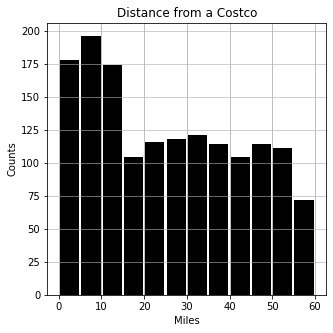

In [115]:
#size, scale = 100, 10
bins = 12
fig = dfrvtemp['Distance'].plot.hist(grid=True, bins=bins, rwidth=0.9,
                   color='black',figsize = (5,5))
plt.title('Distance from a Costco')
plt.xlabel('Miles')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.savefig('CostcoDistance.png', bbox_inches='tight')

In [116]:
# Create map of United States and add markers to the map

address = '48 Contiguous United States'

geolocator = Nominatim(user_agent="US_explorer")
#location = geolocator.geocode(address)
latitude = (dfrvcostco['Latitude'].max()+dfrvcostco['Latitude'].min())/2
longitude = (dfrvcostco['Longitude'].max()+dfrvcostco['Longitude'].min())/2

#latitude = location.latitude
#longitude = location.longitude

map_US = folium.Map(width=800,height=500,location=[latitude, longitude], zoom_start=4, max_zoom = 4, min_zoom = 4)

# add markers to map
for lat, lng, name, city, state in zip(dfrvcostco['Latitude'], dfrvcostco['Longitude'], dfrvcostco['Park Name'],dfrvcostco['City'],dfrvcostco['State']):
    label = '{} {}, {}'.format(name,city,state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#0060A9',
        fill_opacity=0.7,
        parse_html=False).add_to(map_US)  

map_US.save('maprvcostco.html')
map_US


In [117]:
print('There are {:,} RV Parks in {:,} cities and {:,} unique zip codes that are within 60 miles of a Costco.'.format(len(dfrvcostco['Zip Code']),dfrvcostco['City'].nunique(),dfrvcostco['Zip Code'].nunique()))

There are 1,473 RV Parks in 984 cities and 1,146 unique zip codes that are within 60 miles of a Costco.


### 4. Download and Clean Demographic Data from the Census Bureau

The number of  locations to screen is too large to use *k*-means clustering. Thus, I neede to find additional criteria to reduce the number of locations.

My wife and I discussed the demographic factors that we considered most important to us for identifying areas at which we would like to spend more time. We reviewed the demographic data provided in the Census Bureau's ["American Community Survey"](https://www.census.gov/programs-surveys/acs/) ("ACS"). The ACS is an ongoing annual survey covering a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. We decided to analyze data provided in the [ACS 5-Year Data](https://www.census.gov/data/developers/data-sets/acs-5year.html) <u>Data Profiles</u>. Data profiles, the smallest dataset in the ACS, includes over 1,000 variables covering a broadrange  social, economic, housing, and demographic information presented as population counts and percentages.

The list of locations in the United States to consider will be Zip Code Tabulation Areas. According to the Census Bureau, [ZIP Code Tabulation Areas](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html) ("ZCTAs"). Per the Census Burea, ZCTAs "are generalized areal representations of United States Postal Service (USPS) ZIP Code service areas."


In [118]:
HOST = "https://api.census.gov/data"
year = "2018"
dataset = "acs/acs5/profile"
base_url = "/".join([HOST, year, dataset])
predicates = {}
get_vars = ["DP05_0018E","DP02_0067PE","DP03_0062E","DP04_0089E"] 
predfor = "zip code tabulation area:*"#+ziplist
predicates["get"] = ",".join(get_vars)
predicates["for"] = predfor

In [119]:
s=(requests.get(base_url, params=predicates))

col_names=("Median Age",'% Bachelor Degree or Higher',"Median Household Income","Median Home Value","ZCTA") #
dfcensus = pd.DataFrame( columns=col_names, data=s.json()[1:]) # Fix data types  columns=col_names,
dfcensus.dropna(inplace = True)

dfcensus=dfcensus.reindex(columns= ["ZCTA","Median Age",'% Bachelor Degree or Higher',"Median Household Income","Median Home Value"])
dfcensus = dfcensus.sort_values(by=['ZCTA'],ascending = True)

In [120]:
dfcensus['Median Age'] = dfcensus['Median Age'].astype(str).astype(float)
dfcensus['% Bachelor Degree or Higher'] = dfcensus['% Bachelor Degree or Higher'].astype(str).astype(float)
dfcensus['Median Household Income'] = dfcensus['Median Household Income'].astype(str).astype(int)
dfcensus['Median Home Value'] = dfcensus['Median Home Value'].astype(str).astype(int)
dfcensus = dfcensus.sort_values(by=['ZCTA'],ascending = True)
dfcensus = dfcensus.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')

In [121]:
# Delete Rows with values < 0 
dfcensus=dfcensus[dfcensus["Median Age"]>0]
dfcensus=dfcensus[dfcensus["% Bachelor Degree or Higher"]>=0]
dfcensus=dfcensus[dfcensus["Median Household Income"]>0]
dfcensus=dfcensus[dfcensus["Median Home Value"]>0]
include =['float', 'int']

df = dfcensus.describe(include=include).style.format({'Median Age': "{:.1f}",
                                            '% Bachelor Degree or Higher': "{:.1f}%",
                                            'Median Household Income': "${:,.0f}",
                                            'Median Home Value': "${:,.0f}",
                                            })


In [122]:
df = dfcensus[dfcensus['ZCTA']=='77008']
#df= df.drop('ZCTA', 1)
df.set_index("ZCTA", inplace = True)
df.style.format({'Median Age': "{:.1f}",
                '% Bachelor Degree or Higher': "{:.1f}%",
                'Median Household Income': "${:,.0f}",
                'Median Home Value': "${:,.0f}",
                                            })

,Median Age,% Bachelor Degree or Higher,Median Household Income,Median Home Value
ZCTA,,,,
77008,35.2,63.4%,"$104,167","$419,500"


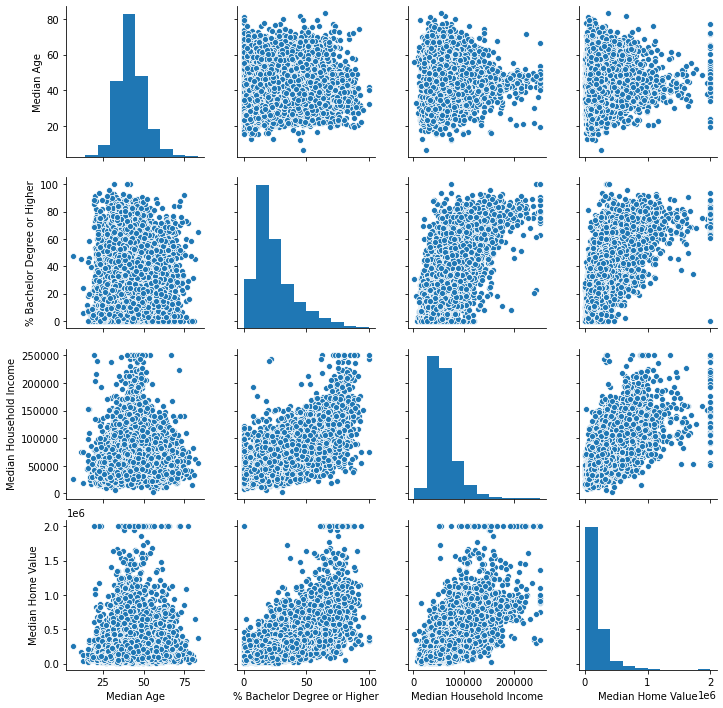

In [123]:
df = dfcensus
df= df.drop('ZCTA', 1)
fig = sns.pairplot(df)
plt.savefig('pairplot.png', bbox_inches='tight')

In [124]:
corrMatrix=df.corr()

df1=corrMatrix

df1['Median Age'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df1['Median Age']], index = df1.index)
df1['% Bachelor Degree or Higher'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df1['% Bachelor Degree or Higher']], index = df1.index)
df1['Median Household Income'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df1['Median Household Income']], index = df1.index)
df1['Median Home Value'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df1['Median Home Value']], index = df1.index)

df1.to_html("Correlation.html")
df1.style.set_table_styles([dict(selector="th",props=[('max-width', '80px')])])

,Median Age,% Bachelor Degree or Higher,Median Household Income,Median Home Value
Median Age,100.0%,1.4%,2.3%,4.0%
% Bachelor Degree or Higher,1.4%,100.0%,72.2%,69.8%
Median Household Income,2.3%,72.2%,100.0%,68.6%
Median Home Value,4.0%,69.8%,68.6%,100.0%


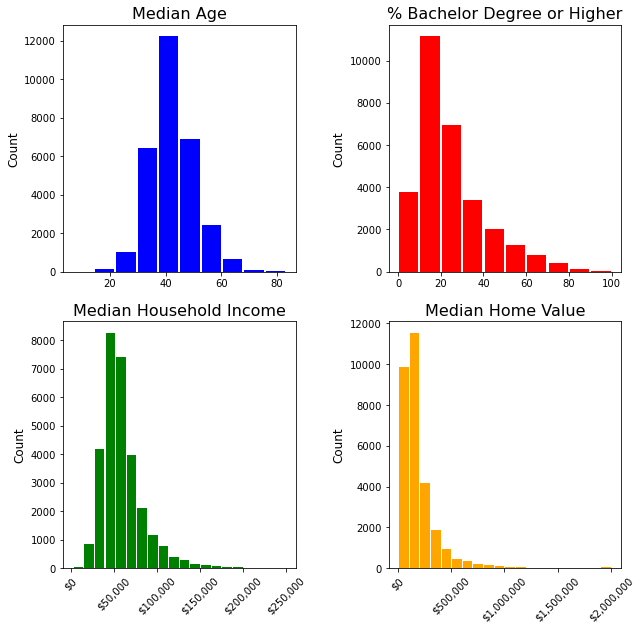

In [125]:
# Histogram
fig, axs = plt.subplots(2, 2, figsize = (10,10))
plt.subplots_adjust(hspace = .2,wspace = 0.4)
#plt.tick_params(axis='x', which='both', bottom=False)

bins = 10

axs[0,0].hist(dfcensus["Median Age"], bins=bins, rwidth=0.9,color='blue')
axs[0,0].set_ylabel('Count', fontsize = '12')
axs[0,0].set_title('Median Age', fontsize = '16')

axs[0,1].hist(dfcensus["% Bachelor Degree or Higher"], bins=bins, rwidth=0.9,color='red')
axs[0,1].set_ylabel('Count', fontsize = '12')
axs[0,1].set_title('% Bachelor Degree or Higher', fontsize = '16')

bins = 20

axs[1,0].hist(dfcensus["Median Household Income"], bins=bins, rwidth=0.9,color='green')
axs[1,0].set_ylabel('Count', fontsize = '12')
axs[1,0].set_title('Median Household Income', fontsize = '16')
axs[1,0].xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
axs[1,0].tick_params(axis='x', labelrotation=45 )

bins = 20

axs[1,1].hist(dfcensus["Median Home Value"], bins=bins, rwidth=0.9,color='orange')
axs[1,1].set_ylabel('Count', fontsize = '12')
axs[1,1].set_title('Median Home Value', fontsize = '16')
axs[1,1].xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
axs[1,1].tick_params(axis='x', labelrotation=45 )
plt.savefig('Histogram.png', bbox_inches='tight')

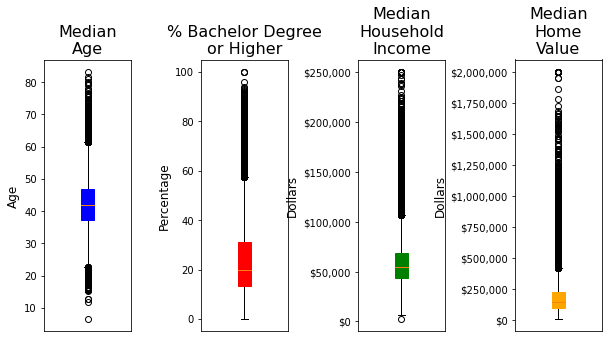

In [126]:
def add_color(bp, color):
    for element in ['boxes']:
        plt.setp(bp[element], color=color)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
plt.subplots_adjust(hspace=.2,wspace = .8)

bp1=axs[0].boxplot(dfcensus["Median Age"],patch_artist=True)
axs[0].set_ylabel('Age', fontsize = '12')
axs[0].set_title('Median\nAge', fontsize = '16')
axs[0].get_xaxis().set_visible(False)
add_color(bp1, "blue")

bp2=axs[1].boxplot(dfcensus["% Bachelor Degree or Higher"],patch_artist=True)
axs[1].set_ylabel('Percentage', fontsize = '12')
axs[1].set_title('% Bachelor Degree\nor Higher', fontsize = '16')
axs[1].get_xaxis().set_visible(False)
add_color(bp2, 'red')

bp3=axs[2].boxplot(dfcensus["Median Household Income"],patch_artist=True)
axs[2].set_ylabel('Dollars', fontsize = '12')
axs[2].set_title('Median\nHousehold\nIncome', fontsize = '16')
axs[2].get_xaxis().set_visible(False)
axs[2].get_yaxis().set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
#axs3.tick_params(axis='x', labelrotation=45 )
add_color(bp3, 'green')

bp4=axs[3].boxplot(dfcensus["Median Home Value"],patch_artist=True)
axs[3].set_ylabel('Dollars', fontsize = '12')
axs[3].set_title('Median\nHome\nValue', fontsize = '16')
axs[3].get_yaxis().set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
axs[3].get_xaxis().set_visible(False)
add_color(bp4, 'orange')


# fill with colors
#colors = ['blue', 'red', 'green','orange']
#
#for patch, color in zip(bplot['boxes'], colors):
#        patch.set_facecolor(color)
plt.savefig('DemoBox.png', bbox_inches='tight')
plt.show()

In [127]:
dftemp=dfcensus
for index in range(dftemp.shape[1]):

    q1_1 = dftemp.iloc[:,1].quantile(.25)
    q1_2 = dftemp.iloc[:,1].quantile(.50)
    q1_3 = dftemp.iloc[:,1].quantile(.75)
    iqr_1 = q1_3 - q1_1

    q2_1 = dftemp.iloc[:,2].quantile(.25)
    q2_2 = dftemp.iloc[:,2].quantile(.50)
    q2_3 = dftemp.iloc[:,2].quantile(.75)
    iqr_2 = q2_3-q2_1

    q3_1 = dftemp.iloc[:,3].quantile(.25)
    q3_2 = dftemp.iloc[:,3].quantile(.50)
    q3_3 = dftemp.iloc[:,3].quantile(.75)
    iqr_3 = q3_3-q3_1

    q4_1 = dftemp.iloc[:,4].quantile(.25)
    q4_2 = dftemp.iloc[:,4].quantile(.50)
    q4_3 = dftemp.iloc[:,4].quantile(.75)
    iqr_4 = q4_3-q4_1
    
dfclean = dftemp[(dftemp.iloc[:,1]>=(q1_1-1.5*iqr_1)) & 
                 (dftemp.iloc[:,1]<=(q1_3+1.5*iqr_1)) &
                 (dftemp.iloc[:,2]>=q2_3) &
                 (dftemp.iloc[:,3]>=q3_1)&
                 (dftemp.iloc[:,4]>=q4_1)&
                 (dftemp.iloc[:,4]<=419500) # dftemp.iloc[:,4].quantile(.92))
                ]
dfclean = dfclean.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
temp=[]
temp=dfclean.describe(include=include)
temp.to_html('demostats.html')
dfclean.describe(include=include).style.format({'Median Age': "{:.1f}",
                                            '% Bachelor Degree or Higher': "{:.1f}%",
                                            'Median Household Income': "${:,.0f}",
                                            'Median Home Value': "${:,.0f}",
                                            })


,Median Age,% Bachelor Degree or Higher,Median Household Income,Median Home Value
count,4938.0,4938.0%,"$4,938","$4,938"
mean,42.0,43.4%,"$78,241","$258,315"
std,7.1,10.3%,"$20,788","$76,031"
min,22.8,31.1%,"$43,506","$95,800"
25%,36.9,35.2%,"$62,717","$197,525"
50%,41.3,40.7%,"$75,974","$252,250"
75%,46.2,49.1%,"$90,960","$316,875"
max,61.4,100.0%,"$250,001","$419,500"


## 4.1 Convert ZCTA to Zip Codes

The datasets for the location of RV parks and Costco Warehouses used Zip Codes as reference, while the dataset for Census data used ZCTAs as references. Since ZCTAs are not an exact geographic match to ZIP Codes, I needed to check if any of the ZCTA codes in the dataset were not the same as the Zip Code for the area. I used the [US Zip Codes Database](https://simplemaps.com/data/us-zip) provided by [Simple Maps](https://simplemaps.com/) to cross reference the ZCTAs selected in the demographic analysis to the related Zip Codes, and modify the demographic analysis dataset to present Zip Codes instead of ZCTAs.

In [128]:
dftemp = pd.DataFrame(dfclean['ZCTA'].unique(),columns = ['ZCTA'])

dfziptozcta = pd.read_excel('zip_to_zcta_2019.xlsx',dtype={0:'str',4:'str'} )

dfziptozcta = dfziptozcta[(dfziptozcta['ZIP_TYPE']=='Zip Code Area') & (dfziptozcta['zip_join_type']=='Zip Matches ZCTA')]
dfdemozip = pd.merge(dftemp, dfziptozcta, on='ZCTA', how='inner')

dfdemozip.drop(dfdemozip.iloc[:,-4:],axis = 1, inplace = True)
dfdemozip.drop(dfdemozip.columns[[0]],axis = 1, inplace = True)
dfdemozip.rename(columns = {'ZIP_CODE':'Zip Code'}, inplace = True) 
dfdemozip.dropna(inplace = True)


### 5. Merge Demographic Dataset with Merged Costco and RV Parks Dataset

In [129]:
# Create Data Frame with Unique Zip Codes of RV Parks within 60 miles of a Costco
dfrvzip = pd.DataFrame(dfrvcostco['Zip Code'].unique(),columns = ['Zip Code'])

dfrvzip = dfrvzip.append({'Zip Code':'77008'},ignore_index = True)
dfrvzip['Latitude']=''
dfrvzip['Longitude']=''
dfrvzip['City']=''
dfrvzip['County']=''
dfrvzip['State']=''
#dfrvzip['Radius']=''
#dfrvzip.shape

search = SearchEngine(simple_zipcode=True)

for index, row in dfrvzip.iterrows():
    dfrvzip.loc[index,'Latitude']=search.by_zipcode(dfrvzip.loc[index,'Zip Code']).lat
    dfrvzip.loc[index,'Longitude']=search.by_zipcode(dfrvzip.loc[index,'Zip Code']).lng
    dfrvzip.loc[index,'City']=search.by_zipcode(dfrvzip.loc[index,'Zip Code']).post_office_city
    dfrvzip.loc[index,'County']=search.by_zipcode(dfrvzip.loc[index,'Zip Code']).county
    dfrvzip.loc[index,'State']=search.by_zipcode(dfrvzip.loc[index,'Zip Code']).state

    
dfrvzip.dropna(inplace = True)
dfrvzip['Latitude']=dfrvzip['Latitude'].astype('float')
dfrvzip['Longitude']=dfrvzip['Longitude'].astype('float')
dfrvzip['City']=dfrvzip['City'].astype('str')
dfrvzip['County']=dfrvzip['County'].astype('str')
dfrvzip['State']=dfrvzip['State'].astype('str')
#dfrvzip['Radius']=dfrvzip['Radius'].astype('float')
dfrvzip = dfrvzip.sort_values(by=['Zip Code'],ascending = True)
dfrvzip = dfrvzip.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
dfrvzip.shape

dfzipdemo = pd.merge(dfrvzip, dfdemozip, on='Zip Code', how='inner')

#Remove Null Values to Avoid Errors
dfzipdemo.dropna(inplace = True)

In [130]:
# Create map of United States and add markers to the map

#address = '48 Contiguous United States'

#geolocator = Nominatim(user_agent="US_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude

map_US = folium.Map(width=800,height=500,location=[latitude, longitude], zoom_start=4, max_zoom = 4)

# add markers to map
for lat, lng, city, state, zipcode in zip(dfzipdemo['Latitude'], 
                                          dfzipdemo['Longitude'], 
                                          dfzipdemo['City'],
                                          dfzipdemo['State'],
                                          dfzipdemo['Zip Code']):
    label = '{}, {} , {}'.format(city,state,zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_US)  

map_US.save('mapzipdemo.html')
map_US


In [131]:
print('The final dataset consists of {:,} unique zip codes in {:,} cities.'.format(dfzipdemo['Zip Code'].nunique(),dfzipdemo['City'].nunique()))

The final dataset consists of 198 unique zip codes in 186 cities.


### 6. Download Venue Data for Selected Zip Codes from Foursquare

To identify which locations are most common with the Houston Heights, I compared the most popular venues within a 5-mile location of the center of each zip code. Data for each zip code was provided by [Foursquare](https://foursquare.com/), a social location service that allows users to explore the world around them. I collected the data using the Foursquare API. Form Foursquare, I requested the 100 most popular venues in each Zip Code within a 5-mile radius. I then removed any Zip Code which did not have at least 50  venues. For each remaining Zip Code, I determined the 5 most popular venues. The table below presents the information for Zip Code 77008, the Zip Code for the Houston Heights neighborhood in which we lived.

In [132]:

CLIENT_ID = 'your Foursquare ID'  
CLIENT_SECRET = 'your Foursquare Secret' 

In [133]:
VERSION = '20200730' # Foursquare API version

In [134]:
def getNearbyVenues(names, latitude, longitude, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitude, longitude):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### To protect my API keys, I have saved the retrieved data as a csv file. The next block loads that file to the dataframe to which the retrieval of data from Foursquare was saved
  
    LIMIT=100  
    rvzip_venues = getNearbyVenues(names=dfzipdemo['Zip Code'],  
                                   latitude=dfzipdemo['Latitude'],  
                                   longitude=dfzipdemo['Longitude'],  
                                   radius=8000)  

In [135]:
rvzip_venues = pd.read_csv('venues.csv',dtype={"Zip Code":'str'})
dftemp = rvzip_venues
rvzip_venues.dtypes

Unnamed: 0              int64
Zip Code               object
Zip Code Latitude     float64
Zip Code Longitude    float64
Venue                  object
Venue Latitude        float64
Venue Longitude       float64
Venue Category         object
dtype: object

In [136]:
value_counts = dftemp['Zip Code'].value_counts()
df_value_counts = pd.DataFrame(value_counts)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Zip Code', '# Venues'] # change column names
df_value_counts = df_value_counts.sort_values(by="Zip Code")

In [137]:
value_counts = rvzip_venues['Zip Code'].value_counts().loc[lambda x : x>=50]
df_value_counts = pd.DataFrame(value_counts)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Zip Code', '# Venues'] # change column names

df_value_counts = df_value_counts.drop('# Venues', 1)
rvzip_venues = pd.merge(rvzip_venues, df_value_counts, on='Zip Code', how='inner')
print('There are {} unique venues over {} unique Zip Codes with 50 venues or more.'.format(len(rvzip_venues['Venue Category'].unique()),len(rvzip_venues['Zip Code'].unique())))

There are 375 unique venues over 109 unique Zip Codes with 50 venues or more.


In [138]:
# one hot encoding
rvzip_onehot = pd.get_dummies(rvzip_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rvzip_onehot['Zip Code'] = rvzip_venues['Zip Code'] 

# move neighborhood column to the first column
fixed_columns = [rvzip_onehot.columns[-1]] + list(rvzip_onehot.columns[:-1])
rvzip_onehot = rvzip_onehot[fixed_columns]

#rvzip_onehot.head()

In [139]:
rvzip_grouped = rvzip_onehot.groupby('Zip Code').mean().reset_index()
#rvzip_grouped.head()

In [140]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [141]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zip_code_venues_sorted = pd.DataFrame(columns=columns)
zip_code_venues_sorted['Zip Code'] = rvzip_grouped['Zip Code']

for ind in np.arange(rvzip_grouped.shape[0]):
    zip_code_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rvzip_grouped.iloc[ind, :], num_top_venues)

temp=[]
temp=zip_code_venues_sorted[zip_code_venues_sorted['Zip Code']=='77008']
temp.to_html("HeightsInfo.html")
temp

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
76,77008,Trail,American Restaurant,Coffee Shop,Gym,Park


## 7. Identify Zip Codes Similar to the Houston Heights

To identify zip codes most similar to the Houston Heights, I used the *k*-means clustering method by using. The *k*-means clustering algorithm identifies *k* number of centroids, then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. It is one of the simplest and most popular unsupervised machine learning algorithms, and is highly suited for this project. For this analysis, I iterated the number of *k*-means to cluster the Zip Codes until 30 or fewer unique Counties with Zip Codes similar to the Houston Heights are identified.

In [142]:
# set number of clusters
#zip_code_venues_sorted.drop('Cluster Labels',1,inplace = True)
Counties=[]

rvzip_grouped_clustering = rvzip_grouped.drop('Zip Code', 1)
rvziptemp=rvzip_grouped['Zip Code']
# run k-means clustering
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rvzip_grouped_clustering)

    # add clustering labels
    zip_code_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

    # merge Zip Code Venues with dfzipdemo to add latitude/longitude, City, County, and State for each Zip Code
    zip_merged = pd.merge(zip_code_venues_sorted,dfzipdemo, how='inner',on = 'Zip Code')
    zip_merged.dropna(inplace=True)
    zip_merged.drop(zip_merged.columns[[2,3,4,5,6]],axis = 1, inplace = True)

    cluster = zip_merged[zip_merged['Zip Code']=='77008'].iloc[0][0]
    dfclustermap = zip_merged[zip_merged['Cluster Labels']==cluster]
    dfclustermap = dfclustermap.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
    if dfclustermap['County'].nunique() <= 35:
        break
    zip_code_venues_sorted.drop('Cluster Labels',1,inplace = True)
dfclustermap = dfclustermap[(dfclustermap['Zip Code']<'77008') | (dfclustermap['Zip Code']>'77008')]

print(dfclustermap.shape, k)

(31, 7) 4


In [143]:
dfclustermap2 = pd.DataFrame(dfclustermap['Zip Code'].unique(),columns = ['Zip Code'])
dfclustermap2['Latitude']=1.1
dfclustermap2['Longitude']=1.1
dfclustermap2['City']='a'
dfclustermap2['County']='b'
dfclustermap2['State']='c'

In [144]:
for index, row in dfclustermap2.iterrows():
#    if index == 25:
#        break
    x=search.by_zipcode(dfclustermap2.loc[index,'Zip Code']).lat
    dfclustermap2.loc[index,'Latitude'] = search.by_zipcode(dfclustermap2.loc[index,'Zip Code']).lat
    dfclustermap2.loc[index,'Longitude'] = search.by_zipcode(dfclustermap2.loc[index,'Zip Code']).lng
    dfclustermap2.loc[index,'City']=search.by_zipcode(dfclustermap2.loc[index,'Zip Code']). post_office_city
    dfclustermap2.loc[index,'County']=search.by_zipcode(dfclustermap2.loc[index,'Zip Code']).county
    dfclustermap2.loc[index,'State']=search.by_zipcode(dfclustermap2.loc[index,'Zip Code']).state

dfclustermap2=dfclustermap2.drop_duplicates(subset = ["County"])
dfclustermap2=dfclustermap2.sort_values(by="State")
dfclustermap2['City']=dfclustermap2['City'].map(lambda x: str(x)[:-4])

dfclustermap2 = dfclustermap2.reset_index(drop = True, inplace=False, level=None, col_level=0, col_fill='')

dfclustermap2.head()

,Zip Code,Latitude,Longitude,City,County,State
0,85745,32.24,-111.07,Tucson,Pima County,AZ
1,80517,40.40,-105.60,Estes Park,Larimer County,CO
2,81601,39.60,-107.30,Glenwood Springs,Garfield County,CO
3,80904,38.86,-104.87,Colorado Springs,El Paso County,CO
4,80110,39.65,-105.01,Englewood,Arapahoe County,CO


In [145]:
finallist = dfclustermap2

finallist = finallist.drop_duplicates(subset = ["County"])
finallist = finallist.sort_values(by="State")
finallist = finallist.reset_index(drop = True, level=None, inplace=False, col_level=1, col_fill='')

# finallist.index = np.arange(1, len(finallist))
finallist.index += 1


## 8. Final Output (Map and List)

In [146]:
# create map
index = 1
map_clusters = folium.Map(width=800,height=500,location=[latitude, longitude], zoom_start=4, min_zoom = 4, max_zoom = 4)

# add markers to map
for lat, lng, city, county, state in zip(finallist['Latitude'], 
                                         finallist['Longitude'], 
                                         finallist['City'],
                                         finallist['County'],
                                         finallist['State']):
    label = '{}, {}, {}'.format(city,county,state)
    label = folium.Popup(label, parse_html=True)

    lat_map = lat
    lng_map = lng

    anchorx = -10
    anchory = 10
    if (index == 7):
        anchorx = 15
        anchory = 10
    
    elif (index == 8):
        anchorx = 15
        anchory = 10

    elif (index == 14):
        anchorx = -2
        anchory = 12

    elif (index == 15):
        anchorx = 10
        anchory = 2

    elif (index == 17):
        anchorx = 20
        anchory = 5

    elif (index == 18):
        anchorx = -2
        anchory = 15

    elif (index==20):
        anchorx = 10
        anchory = 0
        
    elif (index==20):
        anchorx = 10
        anchory = 0

    elif (index == 22):
        anchorx = 10
        anchory = 0
        
    elif (index == 30):
        anchorx = 20
        anchory = 0

    elif (index == 31):
        anchorx = 20
        anchory = 10
        

        
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  
    folium.map.Marker(
        [lat_map, lng_map],        
        icon=DivIcon(
            icon_size=(12,12),
            icon_anchor=(anchorx,anchory),
            html='<div style="font-size: 10pt">%s</div>' % index,
        )
       ).add_to(map_clusters)
    index+=1
map_clusters.save('MapFinal.html')
map_clusters


In [147]:
temp=[]
temp=finallist
temp.drop(temp.columns[[0,1,2]], axis = 1, inplace = True)
temp.to_csv('finallist.csv')
temp.to_html('finallist.html')
temp

,City,County,State
1,Tucson,Pima County,AZ
2,Estes Park,Larimer County,CO
3,Glenwood Springs,Garfield County,CO
4,Colorado Springs,El Paso County,CO
5,Englewood,Arapahoe County,CO
6,Tampa,Hillsborough County,FL
7,Marietta,Cobb County,GA
8,Coeur D Alene,Kootenai County,ID
9,Garden City,Ada County,ID
10,Ypsilanti,Washtenaw County,MI
